In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def getData(name):
  """
  get seaborn sample dataset
  """
  tmp = sns.load_dataset(name)
  tmp = tmp.fillna({
    'age': tmp.age.mean(),
    'embarked': tmp.embarked.mode()[0],
    'deck': tmp.deck.mode()[0],
    'embark_town': tmp.embark_town.mode()[0]})
  tmp = tmp.reset_index()
  tmp.adult_male = tmp.adult_male * 1
  tmp.alone = tmp.alone * 1
  
  tmp.drop('alive', axis=1, inplace=True)
  return spark.createDataFrame(tmp)
data = getData('titanic')
data.printSchema()

root
-- index: long (nullable = true)
-- survived: long (nullable = true)
-- pclass: long (nullable = true)
-- sex: string (nullable = true)
-- age: double (nullable = true)
-- sibsp: long (nullable = true)
-- parch: long (nullable = true)
-- fare: double (nullable = true)
-- embarked: string (nullable = true)
-- class: string (nullable = true)
-- who: string (nullable = true)
-- adult_male: long (nullable = true)
-- deck: string (nullable = true)
-- embark_town: string (nullable = true)
-- alone: long (nullable = true)

In [3]:
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

def getDummy(df, indexCol, categoricalCols, numbericalCols, labelCol=None):
  indexers = [StringIndexer(inputCol=col, outputCol='{}_index'.format(col)) for col in categoricalCols]
  encoders = [OneHotEncoder(inputCol=col.getOutputCol(), outputCol='{}_encode'.format(col.getOutputCol())) for col in indexers]
  assembler = [VectorAssembler(inputCols=[col.getOutputCol() for col in encoders], outputCol='features')]
  pipeline = Pipeline(stages=indexers + encoders + assembler)
  model = pipeline.fit(df)
  data = model.transform(df)
  if labelCol:
    return data.withColumn('label', col(labelCol)).select(indexCol, 'features', 'label')
  return data.select(indexCol, 'features')

indexCol = 'index'
categoricalCols = ['pclass', 'sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alone']
numbericalCols = ['age', 'sibsp', 'parch', 'fare']
labelCol = 'survived'
transformed = getDummy(data, indexCol, categoricalCols, numbericalCols, labelCol)
transformed.show(5)

+-----+--------------------+-----+
index| features|label|
+-----+--------------------+-----+
 0|(19,[0,2,3,5,7,9,...| 0|
 1|(19,[1,4,6,8,10,1...| 1|
 2|(19,[0,3,5,8,10,1...| 1|
 3|(19,[1,3,6,8,10,1...| 1|
 4|(19,[0,2,3,5,7,9,...| 0|
+-----+--------------------+-----+
only showing top 5 rows

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndex = VectorIndexer(inputCol='features', 
                             outputCol='indexedFeatures',
                             maxCategories=2).fit(transformed)
data = featureIndex.transform(transformed)
data.show(5, True)

+-----+--------------------+-----+--------------------+
index| features|label| indexedFeatures|
+-----+--------------------+-----+--------------------+
 0|(19,[0,2,3,5,7,9,...| 0|(19,[0,2,3,5,7,9,...|
 1|(19,[1,4,6,8,10,1...| 1|(19,[1,4,6,8,10,1...|
 2|(19,[0,3,5,8,10,1...| 1|(19,[0,3,5,8,10,1...|
 3|(19,[1,3,6,8,10,1...| 1|(19,[1,3,6,8,10,1...|
 4|(19,[0,2,3,5,7,9,...| 0|(19,[0,2,3,5,7,9,...|
+-----+--------------------+-----+--------------------+
only showing top 5 rows

In [5]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier

train, test = data.randomSplit([0.7, 0.3])
# rf = RandomForestClassifier()
rf = RandomForestRegressor()
pipeline = Pipeline(stages=[featureIndex, rf])
model = pipeline.fit(train)
pred = model.transform(test)
pred = pred.rdd.map(lambda x: {
  "features": x.features,
  "label": x.label,
  "prediction": 1.0 if x.prediction > 0.5 else 0.0
}).toDF()
pred.select('features', 'label', 'prediction').show(5)

+--------------------+-----+----------+
 features|label|prediction|
+--------------------+-----+----------+
(19,[0,3,5,8,10,1...| 1| 1.0|
(19,[1,3,6,8,10,1...| 1| 1.0|
(19,[1,2,3,6,7,9,...| 0| 0.0|
(19,[1,3,6,8,10,1...| 1| 1.0|
(19,[0,2,3,5,7,9,...| 0| 0.0|
+--------------------+-----+----------+
only showing top 5 rows

In [6]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
  labelCol="label", predictionCol="prediction", metricName="accuracy") 
accuracy = evaluator.evaluate(pred) 
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.198473

In [7]:
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix 
import numpy as np 
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
    print("Normalized confusion matrix") 
  else:
    print("Confusion matrix, without normalization")
  print(cm)
  plt.imshow(cm, interpolation="nearest", cmap=cmap) 
  plt.title(title) 
  plt.colorbar() 
  tick_marks = np.arange(len(classes)) 
  plt.xticks(tick_marks, classes, rotation=45) 
  plt.yticks(tick_marks, classes)
  fmt = ".2f" if normalize else "d" 
  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), 
             horizontalalignment="center", 
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout() 
  plt.ylabel("True label") 
  plt.xlabel("Predicted label")

class_temp = pred.select("label").groupBy("label")\
  .count().sort("count", ascending=False).toPandas() 
class_temp = class_temp["label"].values.tolist() 
class_names = map(str, class_temp) 

y_true = pred.select("label") 
y_true = y_true.toPandas()
y_pred = pred.select("prediction").toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_temp) 

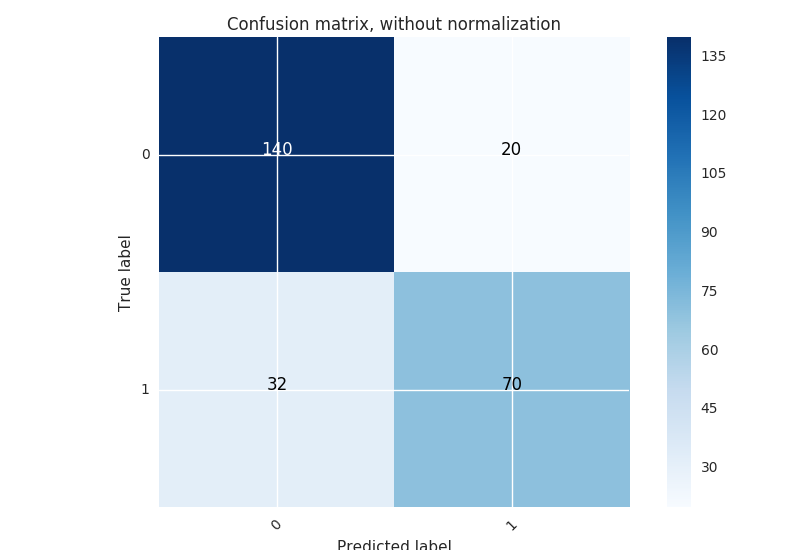

In [8]:
plt.figure()
display(plot_confusion_matrix(cnf_matrix, classes=class_temp, title='Confusion matrix, without normalization'))

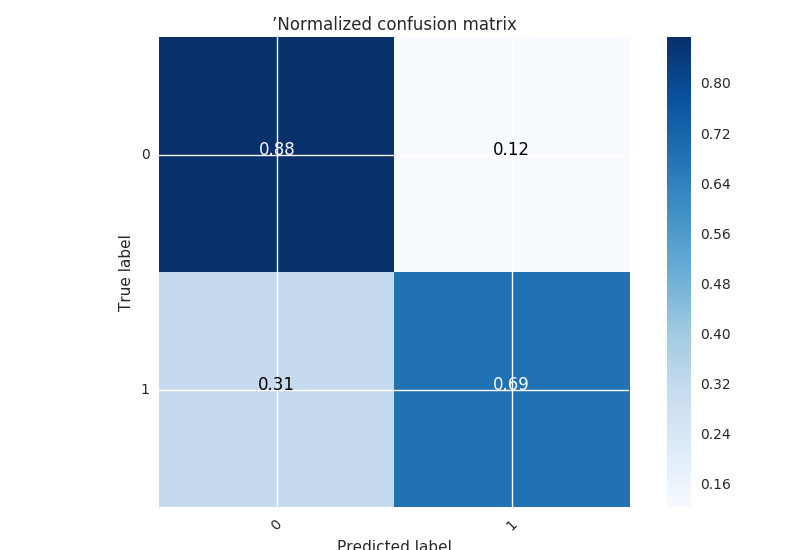

In [9]:
plt.figure()
display(plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True, title='’Normalized confusion matrix'))